## Business Understanding

### Business Problem

Sebuah perusahaan marketing mengalami kesulitan dalam membuktikan efektivitas iklan yang telah mereka luncurkan, terutama dalam hal peningkatan konversi pelanggan. Mereka perlu memahami apakah iklan tersebut benar-benar berdampak positif terhadap perilaku konsumen dan mendorong lebih banyak konversi.

Untuk mengatasi masalah ini, perusahaan menerapkan **A/B testing** dengan membandingkan kinerja antara grup treatment (yang melihat ads) dan grup control (yang melihat *Public Service Announcement*). Melalui metode ini, perusahaan dapat mengevaluasi mana dari dua grup yang menunjukkan tingkat konversi yang lebih tinggi, sehingga mereka dapat mengoptimalkan strategi iklan dan meningkatkan hasil kampanye pemasaran.

### Objective

1. **Mengukur Efektivitas Iklan**: Menganalisis dampak dari berbagai versi iklan terhadap tingkat konversi untuk menentukan strategi yang paling efektif.
2. **Membandingkan Kinerja Iklan dengan Metode Pemasaran Lain**: Menganalisis kinerja iklan dibandingkan dengan pengumuman layanan publik, untuk menentukan pendekatan yang paling berhasil.

### Business Questions

1. Seberapa besar peningkatan tingkat konversi yang dihasilkan oleh iklan dibandingkan dengan pengumuman layanan publik?
2. Apa hari dan jam paling efektif untuk menampilkan iklan berdasarkan jumlah iklan yang dilihat dan konversi yang dicapai?
3. Apakah ada perbedaan signifikan dalam tingkat konversi antara pengguna yang melihat iklan dan pengguna yang melihat pengumuman layanan publik?

### Data Description
- **Index**: Row index
- **user id**: User ID (unique)
- **test group**: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- **converted**: If a person bought the product then True, else is False
- **total ads**: Amount of ads seen by person
- **most ads day**: Day that the person saw the biggest amount of ads
- **most ads hour**: Hour of day that the person saw the biggest amount of ads

### Import Data

In [1]:
# load data manipulation packages
import pandas as pd
import numpy as np
from scipy import stats
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import confint_proportions_2indep

# load data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read the data
path = '/content/marketing_AB.csv'
df = pd.read_csv(path)

df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


### Data Cleaning

In [4]:
# check data shape of the data
df.shape

(588101, 7)

In [5]:
# check data types
df.dtypes

,0
Unnamed: 0,int64
user id,int64
test group,object
converted,bool
total ads,int64
most ads day,object
most ads hour,int64


In [6]:
# check if is there any missing values
df.isnull().sum()

,0
Unnamed: 0,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


In [7]:
# check duplicated data
print(f'Number of duplicated data: {df.duplicated().sum()}')

Number of duplicated data: 0


**Summary**
- Terdapat 588.101 kolom dan 7 fitur dalam dataset ini.
- Ada beberapa kolom, seperti Unnamed: 0 dan user id, yang tidak dibutuhkan dalam analisis, sehingga perlu untuk dihapus.
- Tidak terdapat kesalahan dalam tipe data.
- Tidak ada missing values.
- Tidak ada data yang duplikat.

In [8]:
# drop unnecessary column
df = df.drop(columns = ['Unnamed: 0', 'user id'])

In [9]:
# iterating through categorical column to check unique values
col = df.select_dtypes(include='object').columns
for i in col:
    print(f'Unique value of {i}:')
    print(df[i].unique())
    print('-'*50)

Unique value of test group:
['ad' 'psa']
--------------------------------------------------
Unique value of most ads day:
['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
--------------------------------------------------


In [10]:
# check descriptive data
df.describe()

,total ads,most ads hour
count,588101.000000,588101.000000
mean,24.820876,14.469061
std,43.715181,4.834634
min,1.000000,0.000000
25%,4.000000,11.000000
50%,13.000000,14.000000
75%,27.000000,18.000000
max,2065.000000,23.000000


**Summary**
- Semua value dari categorical kolom sudah terlihat rapi dan konsisten, sehingga tidak diperlukan handling.
- Pada variable total ads, terdapat **indikasi adanya potensi outlier**, sehingga nanti perlu dilakukan pengecekan lebih lanjut mengenai hal ini.

## Exploratory Data Analysis

### Test Group Distribution

In [11]:
# check distribution of test group
df['test group'].value_counts(normalize=True)

,proportion
test group,
ad,0.96
psa,0.04


<Axes: xlabel='test group', ylabel='Count'>

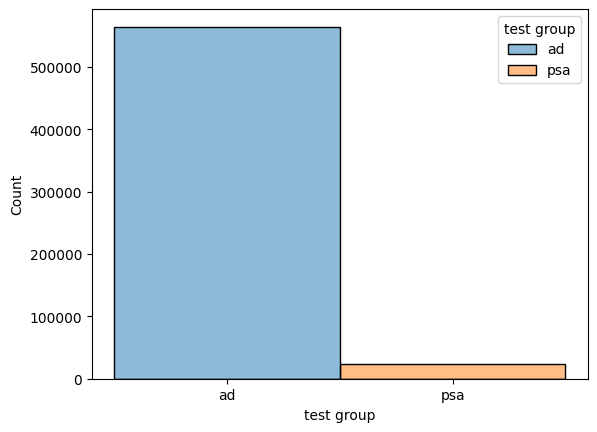

In [12]:
# plot for distribution of test group
sns.histplot(data=df, x='test group', hue='test group')

**Summary**

Variable "test group" memiliki kelas yang imbalance, sehingga diperlukan handling agar tidak menyebabkan bias pada pengujian hipotesis. Pada kasus imbalance yang ekstrem, statistik uji mungkin akan lebih mencerminkan karakteristik dari kelas yang dominan.

### Label Balancing

**Undersampling** adalah teknik untuk menangani data yang tidak seimbang dengan mengurangi jumlah contoh dari kelas mayoritas agar lebih sebanding dengan kelas minoritas. Dalam konteks klasifikasi biner, ini berarti secara acak menghapus sampel dari kelas mayoritas hingga jumlahnya sebanding dengan kelas minoritas. Tujuan utamanya adalah untuk mengurangi bias model terhadap kelas mayoritas, yang sering terjadi ketika model dilatih pada data yang sangat tidak seimbang.

Dalam analisis ini, undersampling dipilih karena tingkat ketidakseimbangan yang ekstrem antara kelas mayoritas dan minoritas, yaitu 0,96:0,4. Menggunakan undersampling memungkinkan penghapusan sebagian besar data mayoritas untuk menghasilkan keseimbangan yang lebih baik, tanpa perlu mengubah distribusi kelas minoritas. Meskipun 90% data mayoritas dihapus, ukuran dataset awal yang cukup besar tetap memungkinkan hasil analisis yang stabil dan andal, dengan jumlah data yang tersisa masih cukup besar untuk menghindari risiko overfitting dan memastikan bahwa model lebih fokus pada pola yang relevan di kedua kelas.

In [13]:
# define X and y for balancing label
X = df.drop(columns = 'test group')
y = df['test group']

# initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=1)

# fit data and concat result of resampled
X_resampled, y_resampled = rus.fit_resample(X, y)
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

df_resampled['test group'].value_counts()

,count
test group,
ad,23524
psa,23524


In [14]:
# filter the data based on test group
df_treatment = df_resampled[df_resampled['test group'] == 'ad']
df_control = df_resampled[df_resampled['test group'] == 'psa']

In [15]:
# define total of control and treatment data
n_control = df_control.shape[0]
n_treat = df_treatment.shape[0]

print(n_control, n_treat)

23524 23524


### Conversion Rate

In [17]:
# calculate number of converted
converted_control = (df_control['converted'] == True).sum()
converted_treat = (df_treatment['converted'] == True).sum()

# calculate conversion rate in each group
cvr_control = converted_control / len(df_control) * 100
cvr_treat = converted_treat / len(df_treatment) * 100

print(f'Conversion rate from control group: {cvr_control:.2f}%')
print(f'Conversion rate from treatment group: {cvr_treat:.2f}%')

Conversion rate from control group: 1.79%
Conversion rate from treatment group: 2.61%


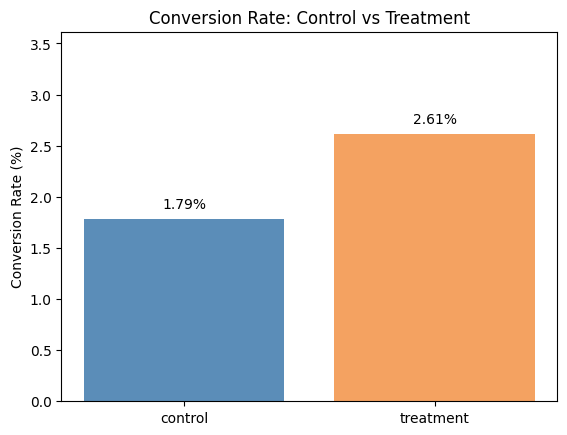

In [18]:
# define groups and conversion rate
groups = ['control', 'treatment']
conversion_rates = [cvr_control, cvr_treat]

# plot for cvr of each group
plt.bar(groups, conversion_rates, color=['#5b8db8', '#f4a261'])
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate: Control vs Treatment')

# annotate each bar
for i, v in enumerate(conversion_rates):
    plt.text(i, v + 0.1, f"{v:.2f}%", ha='center')

plt.ylim(0, max(conversion_rates) + 1)
plt.show()

**Summary**

Conversion rate pada treatment group (2.55%) terlihat lebih tinggi daripada control group (1.79%). Ini menunjukkan bahwa pengguna yang melihat iklan memiliki kecenderungan lebih besar untuk melakukan konversi dibandingkan dengan mereka yang hanya melihat pengumuman layanan publik.

Hasil ini dapat menjadi **indikasi awal** bahwa iklan memiliki dampak positif terhadap konversi, yang berarti strategi pemasaran dengan menggunakan iklan berpotensi lebih efektif dalam mendorong pengguna untuk bertransaksi atau melakukan tindakan yang diinginkan.

### Total Ads Distribution

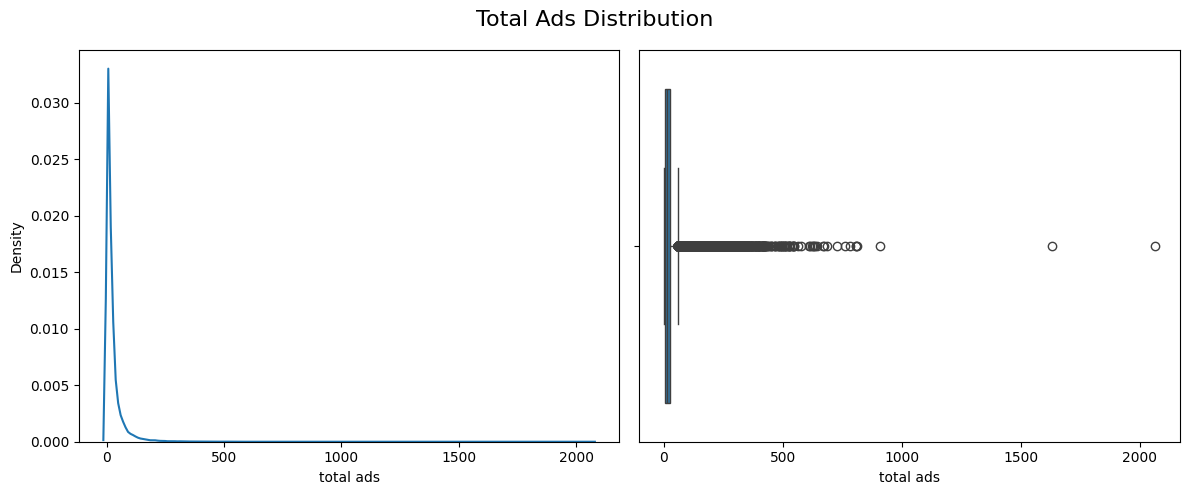

In [19]:
# create a figure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle('Total Ads Distribution', fontsize=16)

# plot kde and boxplot for total ads distribution
sns.kdeplot(data=df_resampled, x='total ads', ax=ax[0])
sns.boxplot(data=df_resampled, x='total ads', ax=ax[1])

plt.tight_layout()
plt.show()

In [20]:
# check the percentile of data
df_resampled['total ads'].describe(percentiles = [.25, .50, .75, .80, .85, .90, .95, .98, .99])

,total ads
count,47048.000000
mean,24.790299
std,43.960927
min,1.000000
25%,4.000000
50%,12.000000
75%,27.000000
80%,33.000000
85%,42.000000
90%,58.000000


**Summary**

Dari kedua plot diatas, terlihat bahwa distribusi dari variable "total ads" adalah skewed. Selain itu dari pengecekan percentile, diketahui bahwa pada percentile 99% datanya mengalami kenaikan yang signifikan. Dengan mempertimbangkan kemungkinan adanya bias, maka perlu dilakukan handling outlier.

In [21]:
# calculate quartile 1, quartile 3 and iqr
q1 = df_resampled['total ads'].quantile(0.25)
q3 = df_resampled['total ads'].quantile(0.75)
iqr = q3 - q1

# filter data for removing outlier
df_cleaned = df_resampled[
    ~(
        (df_resampled['total ads'] < (q1 - 1.5 * iqr)) |
        (df_resampled['total ads'] > (q3 + 1.5 * iqr))
    )
].copy()

In [22]:
# check statistic decribe after removing outlier
df_cleaned['total ads'].describe()

,total ads
count,42731.000000
mean,14.766937
std,14.054348
min,1.000000
25%,4.000000
50%,10.000000
75%,22.000000
max,61.000000


<Axes: xlabel='total ads'>

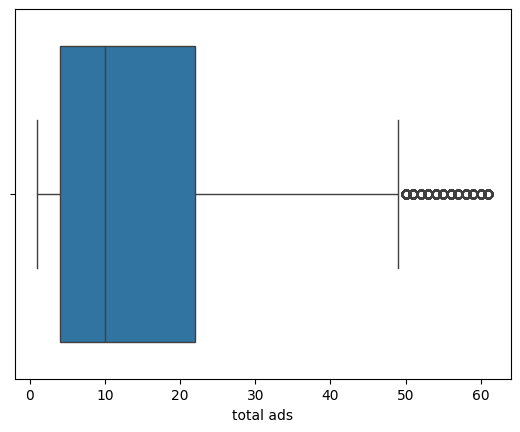

In [23]:
# create boxplot for sanity check
sns.boxplot(data=df_cleaned, x='total ads')

Data telah bebas dari outlier.

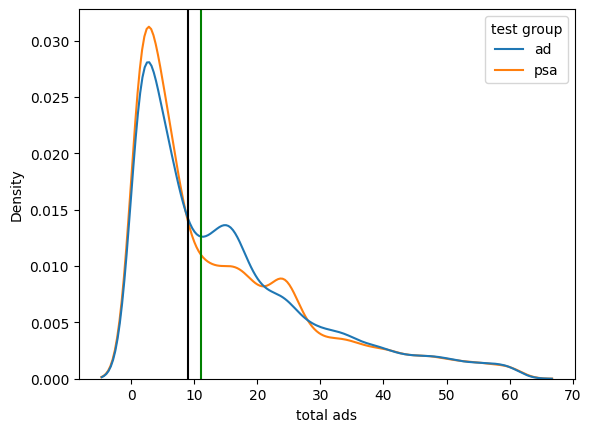

In [24]:
# plotfor the distribution of total ads separated by test group
sns.kdeplot(data=df_cleaned, x='total ads', hue='test group')

# create lines for median of total ads each group
plt.axvline(df_cleaned[df_cleaned['test group'] == 'ad']['total ads'].median(), 0, 1, color='g')
plt.axvline(df_cleaned[df_cleaned['test group'] == 'psa']['total ads'].median(), 0, 1, color='k')

**Summary**

Distribusi antara control dan treatment group terlihat cukup serupa, dengan median jumlah iklan yang dilihat oleh masing-masing kelompok hampir sama, yaitu sekitar 10 iklan. Hal ini mengindikasikan bahwa paparan iklan pada kedua kelompok adalah sebanding, sehingga perbedaan tingkat konversi di antara keduanya kemungkinan besar disebabkan oleh efek lainnya, bukan oleh jumlah iklan yang dilihat.

### Most Ads Hour Distribution

<Axes: xlabel='most ads hour', ylabel='count'>

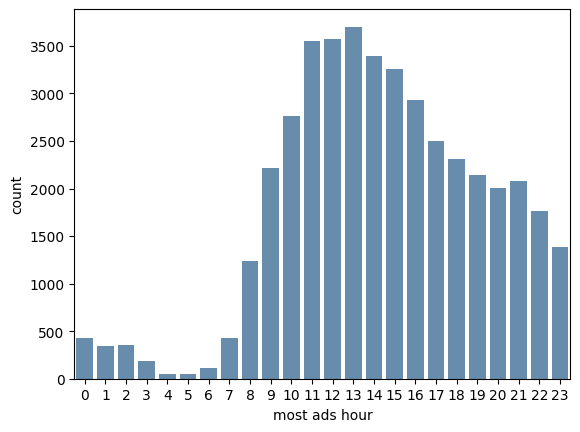

In [25]:
# plot for most ads hour distribution
sns.countplot(data=df_cleaned, x='most ads hour', color='#5b8db8')

In [26]:
# calculate count for each group and most ads hour
control_counts = df_cleaned[df_cleaned['test group'] == 'psa'].groupby('most ads hour').size().reset_index(name='counts')
treatment_counts = df_cleaned[df_cleaned['test group'] == 'ad'].groupby('most ads hour').size().reset_index(name='counts')

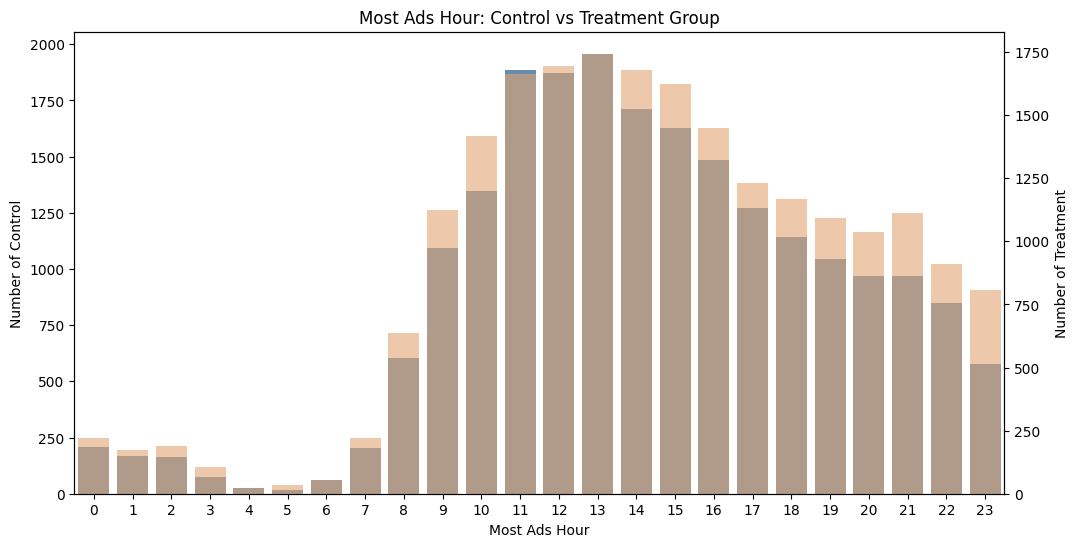

In [27]:
# create figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# plot for control group
sns.barplot(data = control_counts,
            x='most ads hour', y='counts',
            color='#5b8db8', ax=ax1)
ax1.set_ylabel('Number of Control')
ax1.set_xlabel('Most Ads Hour')

# plot for treatment group
ax2 = ax1.twinx()
sns.barplot(data = treatment_counts,
            x='most ads hour', y='counts',
            color='#f4a261', ax=ax2, alpha=0.6)
ax2.set_ylabel('Number of Treatment')

plt.title('Most Ads Hour: Control vs Treatment Group')
plt.show()

**Summary**

Analisis distribusi data menunjukkan bahwa sebagian besar pengguna melihat iklan dalam rentang waktu antara pukul 11 hingga 15 siang. Selain itu, distribusi jumlah iklan yang dilihat oleh pengguna dalam grup kontrol dan treatment menunjukkan pola yang serupa, menandakan bahwa waktu tayang iklan tidak memberikan perbedaan yang signifikan antara kedua grup tersebut.

Dengan kata lain, waktu pengamatan iklan tidak berpengaruh secara berarti terhadap perbedaan konversi yang tercatat antara grup kontrol dan treatment.

### Most Ads Day Distribution

<Axes: xlabel='most ads day', ylabel='count'>

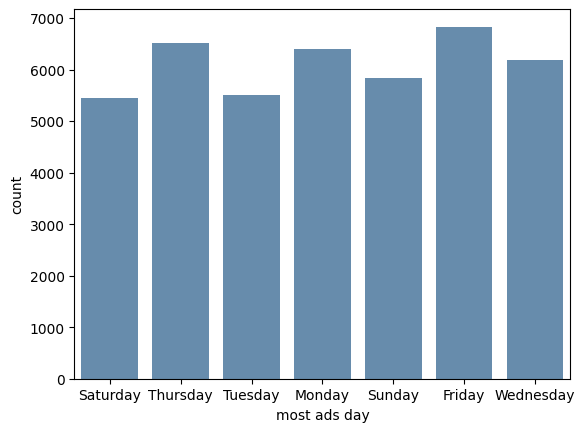

In [28]:
# plot for most ads day distribution
sns.countplot(data=df_cleaned, x='most ads day', color='#5b8db8')

**Summary**

Analisis distribusi penayangan iklan berdasarkan hari menunjukkan bahwa tidak ada perbedaan yang signifikan dalam jumlah tayangan iklan di setiap harinya. Namun, hari Jumat tercatat memiliki jumlah tayangan iklan tertinggi dibandingkan dengan hari-hari lainnya.

## Hypothesis Testing

**Null Hypothesis (H0) and Alternative Hypothesis (H1)**

- Kita ingin membuktikan: Tingkat konversi pengguna yang melihat iklan lebih besar daripada tingkat konversi pengguna yang melihat public service announcements.
- Jika:
    - p1 adalah  treatment conversion rate
    - p2 adalah  control conversion rate
- Maka kita dapat mendefinisikan Null hypothesis (H0) and alternatice hypothesis (H1):
    - H0: p1 = p2
    - H1: p1 > p2
- Siginificance level (alpha) = 0.05

In [29]:
# create count purchase & total observation
count_conversion = [converted_treat, converted_control]
count_observation = [n_treat, n_control]

Dalam pengujian hipotesis, kita dapat menentukan jenis uji sesuai arah perbandingan yang ingin dibuktikan:
- Jika ingin melihat apakah grup perlakuan (treatment) memiliki hasil yang lebih besar dari kontrol (control), maka gunakan alternative = "larger".
    Pada kasus ini:
    - Tujuan: Membuktikan bahwa tingkat konversi grup perlakuan (p1) lebih tinggi dari grup kontrol (p2).
    - Penggunaan alternative = "larger": Menunjukkan bahwa kita hanya ingin melihat apakah ada peningkatan, bukan sekadar perbedaan.

In [30]:
# create alternative
alternative_option = 'larger'

In [31]:
# call the function
z_stat, p_value = proportions_ztest(count = count_conversion,
                                    nobs = count_observation,
                                    alternative = alternative_option)

print(f'Z stat: {z_stat:.4f}')
print(f'P value: {p_value:.4f}')

Z stat: 6.1291
P value: 0.0000


**Create decision rules**

Dalam membuat keputusan uji statistik, kita bisa menggunakan:

- Perbandingan z-statistics dengan critical value
    - One-tailed (right), 𝑧>𝑧𝛼 → reject 𝐻0
- Perbandingan p-value dengan alpha
    - pvalue < 𝛼 → reject 𝐻0

Pada langkah selanjutnya, kita akan mencari nilai kritis untuk dibandingkan dengan statistik z. Kita menggunakan tingkat signifikansi sebesar 5%.

In [32]:
# critical value
alpha = 0.05
z_crit = stats.norm.ppf(1-alpha)

print(f'z critical value: {z_crit:.4f}')

z critical value: 1.6449


In [33]:
# make decision from z-stats and z-crit
if z_stat > z_crit:
    print('Decision: Reject Null Hypothesis')
else:
    print('Decision: Fail to reject Null Hypothesis')

Decision: Reject Null Hypothesis


In [34]:
# comparison of p-value with alpha
if p_value < 0.05:
    print('Decision: Reject Null Hypothesis')
else:
    print('Decision: Fail to reject Null Hypothesis')

Decision: Reject Null Hypothesis


**Summary**
- Ada cukup bukti statistik untuk mendukung bahwa tingkat konversi pada treatment group (yang melihat iklan) lebih besar daripada tingkat konversi pada control group (yang melihat pengumuman layanan publik).
- Temuan ini mengindikasikan bahwa iklan memiliki efek positif terhadap tingkat konversi jika dibandingkan dengan pengumuman layanan publik, yang sejalan dengan hipotesis alternatif (H1).

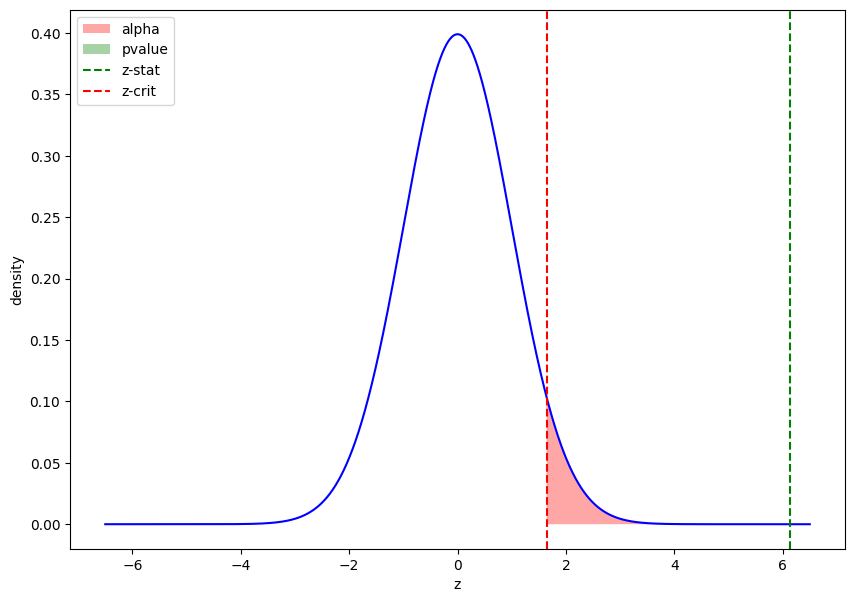

z statistics: 6.1291
z critical: 1.6449


In [35]:
# create a single subplot
fig = plt.subplots(nrows=1, ncols=1, figsize=(10,7))

# define the x-axis range
x = np.arange(-6.5, 6.5, 0.001)
plt.plot(x, stats.norm.pdf(x, 0, 1), color='blue')

# define the range for the alpha area
x_alpha = np.arange(z_crit, 6.5, 0.01)
y_alpha = stats.norm.pdf(x_alpha)
plt.fill_between(x = x_alpha,
                 y1 = y_alpha,
                 facecolor = 'red',
                 alpha = 0.35,
                 label = 'alpha')

# define the range for the p-value area
x_pvalue = np.arange(z_stat, 6.5, 0.01)
y_pvalue = stats.norm.pdf(x_pvalue)
plt.fill_between(x = x_pvalue,
                 y1 = y_pvalue,
                 facecolor = 'green',
                 alpha = 0.35,
                 label = 'pvalue')

# add a vertical dashed line at the z-stat
plt.axvline(np.round(z_stat, 4),
            color = 'green',
            linestyle = '--',
            label = 'z-stat')

# add a vertical dashed line at the z-crit
plt.axvline(np.round(z_crit, 4),
            color = 'red',
            linestyle = '--',
            label = 'z-crit')

plt.legend()
plt.xlabel('z')
plt.ylabel('density')
plt.show()

print(f'z statistics: {z_stat:.4f}')
print(f'z critical: {z_crit:.4f}')

In [36]:
# calculate confidence interval
confidence_interval = confint_proportions_2indep(count1=converted_treat, nobs1=n_treat,
                                                 count2=converted_control, nobs2=n_control,
                                                 compare='diff', alpha=0.05)
print(confidence_interval)

(0.005644539393600456, 0.010952743805665454)


**Summary**

Berdasarkan hasil analisis, terdapat keyakinan 95% bahwa selisih dalam proporsi pengguna yang melakukan konversi (conversion rate) antara grup treatment dan grup kontrol terletak dalam rentang 0.0058 hingga 0.0093. Temuan ini menunjukkan bahwa iklan meningkatkan kemungkinan konversi pengguna sebesar antara 0.0058 hingga 0.0093.

### Conclusion

1. **Efektivitas Iklan**: Hasil analisis menunjukkan bahwa iklan memiliki efek positif terhadap tingkat konversi pengguna, dengan grup treatment (yang melihat iklan) memiliki tingkat konversi lebih tinggi dibandingkan grup kontrol (yang melihat pengumuman layanan publik).
2. ***Confidence Interval***: Dengan keyakinan 95%, selisih proporsi konversi antara grup treatment dan kontrol berada dalam rentang 0.0058 hingga 0.0093, yang menunjukkan bahwa iklan meningkatkan kemungkinan konversi pengguna.
3. **Distribusi Penayangan Iklan**: Analisis distribusi penayangan iklan berdasarkan waktu dan hari menunjukkan bahwa faktor-faktor seperti waktu tayang dan hari tidak berpengaruh signifikan terhadap konversi.